In [1]:
import os
import pandas as pd
import numpy as np
import scipy.io
import re

def load_all_experiments(base_path, experiment_configs):
    """
    Loads all raw .mat files from multiple experiment folders, correctly extracts 
    trial-by-trial data and returns a dictionary of pandas DataFrames.
    """
    all_experiments_data = {}

    for exp_folder, config in experiment_configs.items():
        print(f"--- Processing Experiment: {exp_folder} ---")
        
        exp_path = os.path.join(base_path, exp_folder)
        if not os.path.isdir(exp_path):
            print(f"  - Directory not found. Skipping.")
            continue

        all_trials_list = []
        for dirpath, _, filenames in os.walk(exp_path):
            for filename in filenames:
                if filename.endswith('.mat') and 'sub' in filename:
                    file_path = os.path.join(dirpath, filename)
                    try:
                        mat = scipy.io.loadmat(file_path, simplify_cells=True)
                        
                        if 'task' in mat and isinstance(mat['task'], list) and len(mat['task']) > 1:
                            task_data = mat['task'][1]
                            rand_vars = task_data.get('randVars', {})
                            
                            n_trials_key = config.get('n_trials_key', 'prodcoor')
                            n_trials = len(rand_vars.get(n_trials_key, []))
                            if n_trials == 0: continue

                            subject_id_match = re.search(r'sub(\d+)', filename)
                            subject_id = int(subject_id_match.group(1)) if subject_id_match else -1
                            
                            trial_vars = {}
                            for key, path in config['vars'].items():
                                if 'randVars' in path:
                                    trial_vars[key] = rand_vars.get(path.split('.')[1])
                                else:
                                    trial_vars[key] = task_data.get(path)
                            
                            for i in range(n_trials):
                                trial_dict = {'subject_id': subject_id, 'trial_index': i + 1}
                                for key, data_array in trial_vars.items():
                                    if data_array is not None and i < len(data_array):
                                        trial_dict[key] = data_array[i]
                                
                                all_trials_list.append(trial_dict)

                    except Exception as e:
                        print(f"   - Warning: Could not fully process '{filename}'. Error: {e}")
        
        if all_trials_list:
            df = pd.DataFrame(all_trials_list)
            
            if 'estimate_coords' in df.columns:
                coords = df['estimate_coords'].apply(
                    lambda x: pd.Series(x, index=['estimate_x', 'estimate_y']) if isinstance(x, (list, np.ndarray)) and len(x) >= 2 else pd.Series([np.nan, np.nan], index=['estimate_x', 'estimate_y'])
                )
                df = pd.concat([df.drop('estimate_coords', axis=1), coords], axis=1)

            all_experiments_data[exp_folder] = df
            print(f"  - ✅ Success! Assembled {len(df)} total trial entries.")
        else:
            print(f"  - ❌ No data found in this directory.")
            
    return all_experiments_data

# =================================================================
# --- MAIN EXECUTION ---
# =================================================================

# 1. Define the base path and experiment configurations
BASE_DATA_PATH = r'D:' 

EXPERIMENT_CONFIGS = {
    'data01_direction4priors': {
        'n_trials_key': 'prodcoor',
        'vars': {
            'motion_direction': 'randVars.myRandomDir',
            'motion_coherence': 'randVars.myRandomCoh',
            'reaction_time': 'reactionTime',
            'estimate_coords': 'randVars.prodcoor'
        }
    },
    'data02_direction1prior': {
        'n_trials_key': 'prodcoor',
        'vars': {
            'motion_direction': 'randVars.myRandomDir',
            'motion_coherence': 'randVars.myRandomCoh',
            'reaction_time': 'reactionTime',
            'estimate_coords': 'randVars.prodcoor'
        }
    },
    'data03_orientation': {
        'n_trials_key': 'prodcoor',
        'vars': {
            'stimulus_orientation': 'randVars.myRandomloc', 
            'stimulus_contrast': 'randVars.myRandomCon',   
            'reaction_time': 'reactionTime',
            'estimate_coords': 'randVars.prodcoor'
        }
    }
}

# 2. Load all datasets
dataframes = load_all_experiments(BASE_DATA_PATH, EXPERIMENT_CONFIGS)

# 3. Display the head of each created DataFrame
print("\n" + "="*50)
print("              DATA LOADING COMPLETE")
print("="*50)

if dataframes:
    for exp_name, df in dataframes.items():
        print(f"\n--- DataFrame Head for: '{exp_name}' ---")
        print(f"Total entries loaded: {len(df)}")
        print(df.head())
else:
    print("\nNo dataframes were created.")

--- Processing Experiment: data01_direction4priors ---
  - ✅ Success! Assembled 97250 total trial entries.
--- Processing Experiment: data02_direction1prior ---
  - ✅ Success! Assembled 60500 total trial entries.
--- Processing Experiment: data03_orientation ---
  - ✅ Success! Assembled 70500 total trial entries.

              DATA LOADING COMPLETE

--- DataFrame Head for: 'data01_direction4priors' ---
Total entries loaded: 97250
   subject_id  trial_index  motion_direction  motion_coherence  estimate_x  \
0           1            1             225.0              0.12   -1.749685   
1           1            2             225.0              0.12   -1.819693   
2           1            3             235.0              0.06   -1.562674   
3           1            4             225.0              0.06   -1.601388   
4           1            5             215.0              0.24   -1.639461   

   estimate_y  
0   -1.785666  
1   -1.714269  
2   -1.951422  
3   -1.919781  
4   -1.887371  


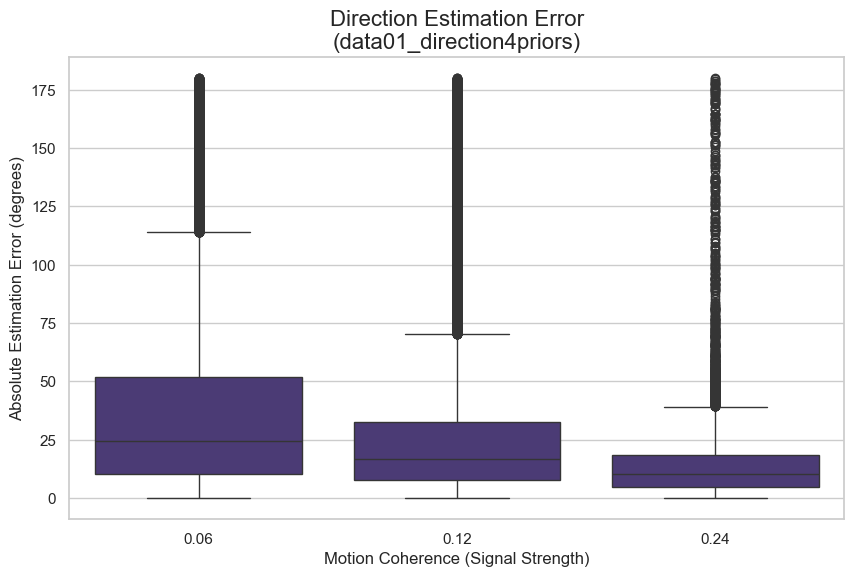

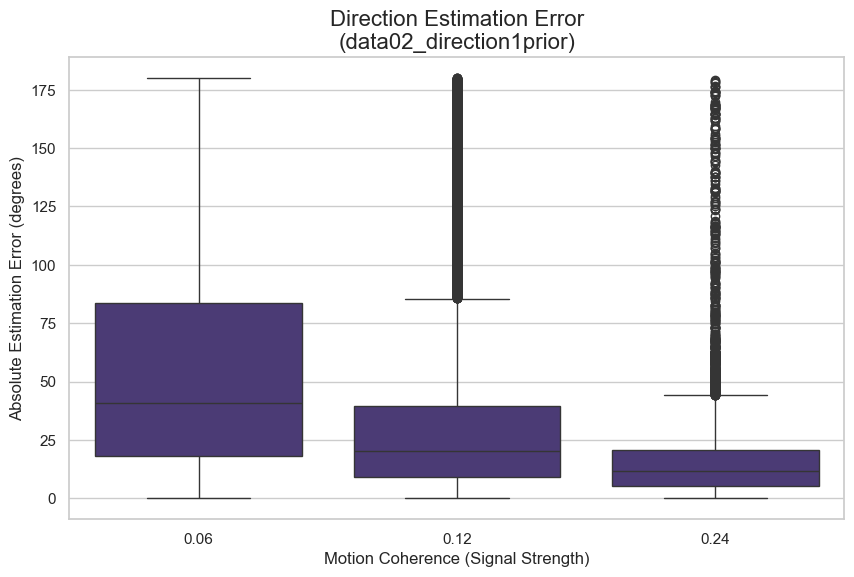

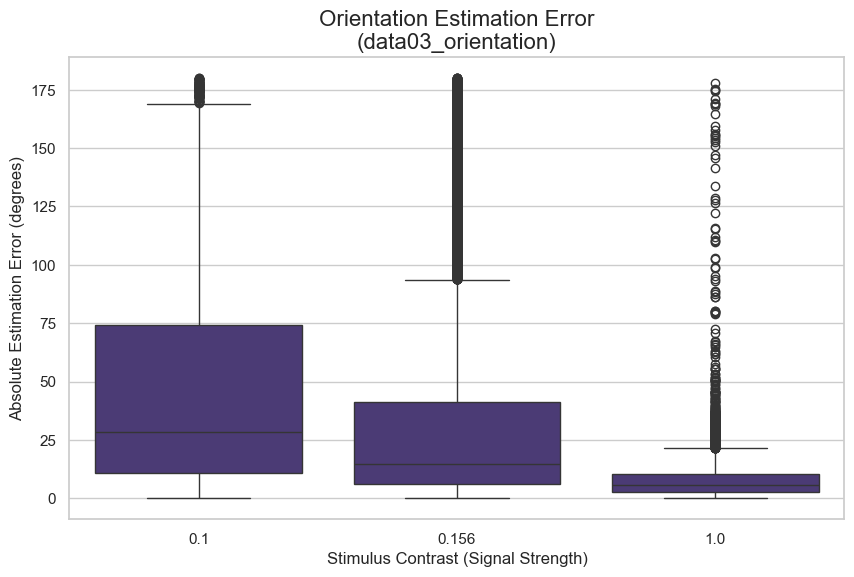

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Set the plotting style for all subsequent plots
sns.set_theme(style="whitegrid", palette="viridis")

# Loop through each experiment's DataFrame in the dictionary
for exp_name, df in dataframes.items():

    # --- 1. Identify the correct column names for this experiment ---
    if 'direction' in exp_name:
        true_angle_col = 'motion_direction'
        strength_col = 'motion_coherence'
        x_label = 'Motion Coherence (Signal Strength)'
        plot_title = 'Direction Estimation Error'
    elif 'orientation' in exp_name:
        true_angle_col = 'stimulus_orientation'
        strength_col = 'stimulus_contrast'
        x_label = 'Stimulus Contrast (Signal Strength)'
        plot_title = 'Orientation Estimation Error'
    else:
        print("  - Could not determine experiment type. Skipping.")
        continue

    # --- 2. Calculate the Estimation Error ---
    # Calculate the angle of the subject's estimate from the x, y coordinates
    df['estimated_angle'] = np.degrees(np.arctan2(df['estimate_y'], df['estimate_x']))
    
    # Adjust the angle to be in the [0, 360] degree range
    df.loc[df['estimated_angle'] < 0, 'estimated_angle'] += 360

    # Calculate the raw angular error
    error = df['estimated_angle'] - df[true_angle_col]

    # Wrap the error to the shortest angle, from -180 to 180 degrees
    error[error > 180] -= 360
    error[error < -180] += 360
    df['estimation_error'] = error

    # --- 3. Create the Visualization ---
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x=strength_col, y=abs(df['estimation_error']))
    
    plt.title(f'{plot_title}\n({exp_name})', fontsize=16)
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel('Absolute Estimation Error (degrees)', fontsize=12)
    plt.show()